In [1]:
import numpy as np
import pyuvdata
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
from dwcal import delay_weighted_cal as dwcal

In [2]:
def fft_visibilities(uv):
    delay_array = np.fft.fftfreq(uv.Nfreqs, d=uv.channel_width)
    delay_array = np.fft.fftshift(delay_array)
    fft_abs = np.abs(np.fft.fftshift(np.fft.fft(uv.data_array, axis=2), axes=2))
    return fft_abs, delay_array

def calculate_binned_rms(
    vis_array, uvw_array, Nfreqs, nbins=100, min_val=None, max_val=None
):

    bl_lengths = np.sqrt(np.sum(uvw_array**2.0, axis=1))
    if min_val is None:
        min_val = np.min(bl_lengths)
    if max_val is None:
        max_val = np.max(bl_lengths)
    bl_bin_edges = np.linspace(min_val, max_val, num=nbins + 1)
    binned_rms_squared = np.full([nbins, Nfreqs], np.nan, dtype="float")
    for bin_ind in range(nbins):
        bl_inds = np.where(
            (bl_lengths > bl_bin_edges[bin_ind])
            & (bl_lengths <= bl_bin_edges[bin_ind + 1])
        )[0]
        if len(bl_inds) > 0:
            binned_rms_squared[bin_ind, :] = np.mean(
                vis_array[bl_inds, 0, :, 0] ** 2.0, axis=0
            )

    binned_rms = binned_rms_squared**0.5
    return binned_rms, bl_bin_edges

def calculate_measurements_per_bin(
    vis_array, uvw_array, Nfreqs, nbins=100, min_val=None, max_val=None
):

    bl_lengths = np.sqrt(np.sum(uvw_array**2.0, axis=1))
    if min_val is None:
        min_val = np.min(bl_lengths)
    if max_val is None:
        max_val = np.max(bl_lengths)
    bl_bin_edges = np.linspace(min_val, max_val, num=nbins + 1)
    bin_measurements = np.zeros([nbins, Nfreqs], dtype="int")
    for bin_ind in range(nbins):
        bl_inds = np.where(
            (bl_lengths > bl_bin_edges[bin_ind])
            & (bl_lengths <= bl_bin_edges[bin_ind + 1])
        )[0]
        if len(bl_inds) > 0:
            bin_measurements[bin_ind, :] = np.size(bl_inds)

    return binned_rms, bl_bin_edges

def plot_delay_spectra(
    binned_delay_spec,
    bin_edges,
    delay_array,
    title="",
    add_lines=[],
    vmin=None,
    vmax=None,
    c=3e8,
    savepath=None,
):

    
    if vmin is not None:
        if vmin < 0:
            use_cmap = matplotlib.cm.get_cmap("seismic").copy()
            use_cmap.set_bad(color="whitesmoke")
            norm = matplotlib.colors.SymLogNorm(linthresh=1e-3, vmin=vmin, vmax=vmax)
        else:
            use_cmap = matplotlib.cm.get_cmap("plasma").copy()
            use_cmap.set_bad(color="whitesmoke")
            norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        if np.min(binned_delay_spec) < 0:
            use_cmap = matplotlib.cm.get_cmap("seismic").copy()
            use_cmap.set_bad(color="whitesmoke")
            norm = matplotlib.colors.SymLogNorm(vmin=vmin, vmax=vmax)
        else:
            use_cmap = matplotlib.cm.get_cmap("plasma").copy()
            use_cmap.set_bad(color="whitesmoke")
            norm = matplotlib.colors.LogNorm(linthresh=1e-3, vmin=vmin, vmax=vmax)
    plt.imshow(
        binned_delay_spec.T,
        origin="lower",
        interpolation="none",
        cmap=use_cmap,
        norm=norm,
        extent=[
            np.min(bin_edges),
            np.max(bin_edges),
            np.min(delay_array) * 1e6,
            np.max(delay_array) * 1e6,
        ],
        aspect="auto",
    )

    for line_slope in add_lines:
        plt.plot(
            [np.min(bin_edges), np.max(bin_edges)],
            [
                np.min(bin_edges) / c * line_slope * 1e6,
                np.max(bin_edges) / c * line_slope * 1e6,
            ],
            "--",
            color="white",
            linewidth=1.0,
        )
        plt.plot(
            [np.min(bin_edges), np.max(bin_edges)],
            [
                -np.min(bin_edges) / c * line_slope * 1e6,
                -np.max(bin_edges) / c * line_slope * 1e6,
            ],
            "--",
            color="white",
            linewidth=1.0,
        )

    cbar = plt.colorbar(extend="both")
    cbar.ax.set_ylabel("Visibility Error RMS (Jy)", rotation=270, labelpad=15)
    plt.xlabel("Baseline Length (m)")
    #plt.ylim([-3, 3])
    plt.ylabel("Delay ($\mu$s)")
    plt.title(title)
    if savepath is not None:
        plt.savefig(savepath, dpi=600)
        plt.close()
    else:
        plt.show()

In [22]:
data, model = dwcal.get_test_data(
    model_path="/Users/ruby/Astro/FHD_outputs/fhd_rlb_model_GLEAM_bright_sources_Apr2022",
    model_use_model=True,
    data_path="/Users/ruby/Astro/FHD_outputs/fhd_rlb_model_GLEAM_Apr2022",
    data_use_model=True,
    obsid="1061316296",
    pol="XX",
    use_autos=False,
    debug_limit_freqs=None,
    use_antenna_list=None,
    use_flagged_baselines=False,
)

diff_vis = data.diff_vis(model, inplace=False)

diff_fft_abs, delay_array = fft_visibilities(diff_vis)
bl_lengths = np.sqrt(np.sum(diff_vis.uvw_array**2.0, axis=1))

Loading model from /Users/ruby/Astro/FHD_outputs/fhd_rlb_model_GLEAM_bright_sources_Apr2022, using the FHD run's model visibilities.


Telescope location derived from obs lat/lon/alt values does not match the location in the layout file. Using the value from known_telescopes.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
There is a gap in the times of baseline (0, 0). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 1). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 2). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 3). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 4). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 5). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 6). The output may include averages across long time gaps.
There is a gap in the times of base

There is a gap in the times of baseline (6, 35). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 36). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 37). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 38). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 39). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 40). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 41). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 42). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 43). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 44). The output may 

There is a gap in the times of baseline (12, 98). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 99). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 100). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 101). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 102). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 103). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 104). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 105). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 106). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 107

There is a gap in the times of baseline (19, 105). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 106). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 107). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 108). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 109). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 110). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 111). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 112). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 113). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 1

There is a gap in the times of baseline (27, 66). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 67). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 68). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 69). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 70). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 71). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 72). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 73). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 74). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 75). The o

There is a gap in the times of baseline (35, 81). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 82). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 83). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 84). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 85). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 86). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 87). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 88). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 89). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 90). The o

There is a gap in the times of baseline (44, 74). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 75). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 77). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 78). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 79). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 80). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 81). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 82). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 83). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 84). The o

There is a gap in the times of baseline (54, 77). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 78). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 79). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 80). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 81). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 82). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 83). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 84). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 85). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 86). The o

There is a gap in the times of baseline (66, 67). The output may include averages across long time gaps.
There is a gap in the times of baseline (66, 68). The output may include averages across long time gaps.
There is a gap in the times of baseline (66, 69). The output may include averages across long time gaps.
There is a gap in the times of baseline (66, 70). The output may include averages across long time gaps.
There is a gap in the times of baseline (66, 71). The output may include averages across long time gaps.
There is a gap in the times of baseline (66, 72). The output may include averages across long time gaps.
There is a gap in the times of baseline (66, 73). The output may include averages across long time gaps.
There is a gap in the times of baseline (66, 74). The output may include averages across long time gaps.
There is a gap in the times of baseline (66, 75). The output may include averages across long time gaps.
There is a gap in the times of baseline (66, 77). The o

There is a gap in the times of baseline (81, 108). The output may include averages across long time gaps.
There is a gap in the times of baseline (81, 109). The output may include averages across long time gaps.
There is a gap in the times of baseline (81, 110). The output may include averages across long time gaps.
There is a gap in the times of baseline (81, 111). The output may include averages across long time gaps.
There is a gap in the times of baseline (81, 112). The output may include averages across long time gaps.
There is a gap in the times of baseline (81, 113). The output may include averages across long time gaps.
There is a gap in the times of baseline (81, 114). The output may include averages across long time gaps.
There is a gap in the times of baseline (81, 115). The output may include averages across long time gaps.
There is a gap in the times of baseline (81, 116). The output may include averages across long time gaps.
There is a gap in the times of baseline (81, 1

There is a gap in the times of baseline (103, 109). The output may include averages across long time gaps.
There is a gap in the times of baseline (103, 110). The output may include averages across long time gaps.
There is a gap in the times of baseline (103, 111). The output may include averages across long time gaps.
There is a gap in the times of baseline (103, 112). The output may include averages across long time gaps.
There is a gap in the times of baseline (103, 113). The output may include averages across long time gaps.
There is a gap in the times of baseline (103, 114). The output may include averages across long time gaps.
There is a gap in the times of baseline (103, 115). The output may include averages across long time gaps.
There is a gap in the times of baseline (103, 116). The output may include averages across long time gaps.
There is a gap in the times of baseline (103, 117). The output may include averages across long time gaps.
There is a gap in the times of baseli

Loading data from /Users/ruby/Astro/FHD_outputs/fhd_rlb_model_GLEAM_Apr2022, using the FHD run's model visibilities.


Telescope location derived from obs lat/lon/alt values does not match the location in the layout file. Using the value from known_telescopes.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
There is a gap in the times of baseline (0, 0). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 1). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 2). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 3). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 4). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 5). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 6). The output may include averages across long time gaps.
There is a gap in the times of base

There is a gap in the times of baseline (6, 33). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 34). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 35). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 36). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 37). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 38). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 39). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 40). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 41). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 42). The output may 

There is a gap in the times of baseline (12, 89). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 90). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 91). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 92). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 93). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 94). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 95). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 96). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 97). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 98). The o

There is a gap in the times of baseline (19, 88). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 89). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 90). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 91). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 92). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 93). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 94). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 95). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 96). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 97). The o

There is a gap in the times of baseline (27, 37). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 38). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 39). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 40). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 41). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 42). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 43). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 44). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 45). The output may include averages across long time gaps.
There is a gap in the times of baseline (27, 46). The o

There is a gap in the times of baseline (35, 64). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 65). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 66). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 67). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 68). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 69). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 70). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 71). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 72). The output may include averages across long time gaps.
There is a gap in the times of baseline (35, 73). The o

There is a gap in the times of baseline (44, 72). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 73). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 74). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 75). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 77). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 78). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 79). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 80). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 81). The output may include averages across long time gaps.
There is a gap in the times of baseline (44, 82). The o

There is a gap in the times of baseline (54, 73). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 74). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 75). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 77). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 78). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 79). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 80). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 81). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 82). The output may include averages across long time gaps.
There is a gap in the times of baseline (54, 83). The o

There is a gap in the times of baseline (65, 112). The output may include averages across long time gaps.
There is a gap in the times of baseline (65, 113). The output may include averages across long time gaps.
There is a gap in the times of baseline (65, 114). The output may include averages across long time gaps.
There is a gap in the times of baseline (65, 115). The output may include averages across long time gaps.
There is a gap in the times of baseline (65, 116). The output may include averages across long time gaps.
There is a gap in the times of baseline (65, 117). The output may include averages across long time gaps.
There is a gap in the times of baseline (65, 118). The output may include averages across long time gaps.
There is a gap in the times of baseline (65, 119). The output may include averages across long time gaps.
There is a gap in the times of baseline (65, 120). The output may include averages across long time gaps.
There is a gap in the times of baseline (65, 1

There is a gap in the times of baseline (80, 117). The output may include averages across long time gaps.
There is a gap in the times of baseline (80, 118). The output may include averages across long time gaps.
There is a gap in the times of baseline (80, 119). The output may include averages across long time gaps.
There is a gap in the times of baseline (80, 120). The output may include averages across long time gaps.
There is a gap in the times of baseline (80, 121). The output may include averages across long time gaps.
There is a gap in the times of baseline (80, 122). The output may include averages across long time gaps.
There is a gap in the times of baseline (80, 123). The output may include averages across long time gaps.
There is a gap in the times of baseline (80, 124). The output may include averages across long time gaps.
There is a gap in the times of baseline (80, 125). The output may include averages across long time gaps.
There is a gap in the times of baseline (80, 1

There is a gap in the times of baseline (101, 115). The output may include averages across long time gaps.
There is a gap in the times of baseline (101, 116). The output may include averages across long time gaps.
There is a gap in the times of baseline (101, 117). The output may include averages across long time gaps.
There is a gap in the times of baseline (101, 118). The output may include averages across long time gaps.
There is a gap in the times of baseline (101, 119). The output may include averages across long time gaps.
There is a gap in the times of baseline (101, 120). The output may include averages across long time gaps.
There is a gap in the times of baseline (101, 121). The output may include averages across long time gaps.
There is a gap in the times of baseline (101, 122). The output may include averages across long time gaps.
There is a gap in the times of baseline (101, 123). The output may include averages across long time gaps.
There is a gap in the times of baseli

use_flagged_baselines=False. Removing baselines with flags.
Fraction of data removed: 0.29671291088613927


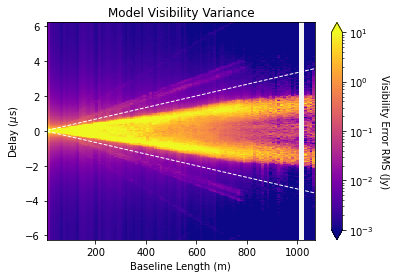

In [23]:
binned_delay_spec_diff, bin_edges = calculate_binned_rms(
    diff_fft_abs, diff_vis.uvw_array, diff_vis.Nfreqs
)
plot_delay_spectra(
    binned_delay_spec_diff**2.,
    bin_edges,
    delay_array,
    title="Model Visibility Variance",
    add_lines=[1.0],
    vmin=1e-3,
    vmax=1e1,
)

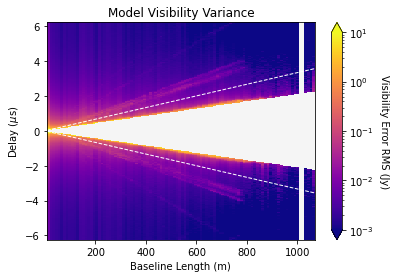

In [90]:
diff_fft_abs_no_wedge = np.copy(diff_fft_abs)

boundary_slope = 0.6284790822752272
wedge_buffer = 0.
c = 3e8

for delay_ind, delay_val in enumerate(delay_array):
    wedge_bls = np.where(
        bl_lengths * boundary_slope / c + wedge_buffer > np.abs(delay_val)
    )[0]
    if len(wedge_bls) > 0:
        diff_fft_abs_no_wedge[wedge_bls, 0, delay_ind, 0] = np.nan

binned_delay_spec_no_wedge, bin_edges = calculate_binned_rms(
    diff_fft_abs_no_wedge, diff_vis.uvw_array, diff_vis.Nfreqs
)
plot_delay_spectra(
    binned_delay_spec_no_wedge**2.,
    bin_edges,
    delay_array,
    title="Model Visibility Variance",
    add_lines=[1.0],
    vmin=1e-3,
    vmax=1e1,
)

In [98]:
print(np.nanmax(diff_fft_abs_no_wedge**2.))

1895.7518587583768


In [99]:
alt_window_vis_vals=np.nanmean(diff_fft_abs_no_wedge[:,0,:,0]**2., axis=0)

Mean of empty slice


In [100]:
print(np.nanmax(alt_window_vis_vals))

273.6505097935324


# Fit weighting matrix with Gaussian

In [74]:
boundary_slope = 0.6284790822752272
wedge_buffer = 0.
c = 3e8

wedge_vis_sum = 0.
wedge_vis_n = 0
for delay_ind, delay_val in enumerate(delay_array):
    wedge_bls = np.where(
        bl_lengths * boundary_slope / c + wedge_buffer > np.abs(delay_val)
    )[0]
    if len(wedge_bls) > 0:
        wedge_vis_sum += np.sum(diff_fft_abs[wedge_bls, 0, delay_ind, 0]**2.)
        wedge_vis_n += len(wedge_bls)

In [75]:
print(wedge_vis_sum/wedge_vis_n)

7.101176738469631


In [76]:
window_vis_sum = np.sum(diff_fft_abs**2.) - wedge_vis_sum
window_vis_n = np.size(diff_fft_abs) - wedge_vis_n
print(window_vis_sum/window_vis_n)

0.09312118661179891


In [77]:
# Confirm window average
window_vis_sum = 0.
window_vis_n = 0
for delay_ind, delay_val in enumerate(delay_array):
    window_bls = np.where(
        bl_lengths * boundary_slope / c + wedge_buffer <= np.abs(delay_val)
    )[0]
    if len(window_bls) > 0:
        window_vis_sum += np.sum(diff_fft_abs[window_bls, 0, delay_ind, 0]**2.)
        window_vis_n += len(window_bls)
        
print(window_vis_sum/window_vis_n)

0.09312118661179813


In [129]:
window_vis_vals = np.full(data.Nfreqs, np.nan)
window_vis_n = np.full(data.Nfreqs, 0)
wedge_buffer = 0*6.5e-8
for delay_ind, delay_val in enumerate(delay_array):
    window_bls = np.where(
        bl_lengths * boundary_slope / c + wedge_buffer <= np.abs(delay_val)
    )[0]
    if len(window_bls) > 0:
        window_vis_vals[delay_ind] = np.mean(diff_fft_abs[window_bls, 0, delay_ind, 0]**2.)
        window_vis_n[delay_ind] = len(window_bls)

In [130]:
print(np.nanmax(window_vis_vals))

273.6505097935323


In [135]:
def gaussian_fit_cost_func(x, delay_array, window_vis_vals, window_vis_n):
    amp = x[0]
    sigma = x[1]
    min_val = x[2]
    
    window_vis_vals_use = np.copy(window_vis_vals)
    window_vis_vals_use[np.where(window_vis_vals_use > 1)[0]] = np.nan
    
    gaussian_func = amp*np.exp(-delay_array**2/sigma**2/2) + min_val
    return np.nanmean(window_vis_n*(window_vis_vals_use - gaussian_func)**2)

gaussian_fit_result = scipy.optimize.minimize(
    gaussian_fit_cost_func,
    [250, 1e-6, 0],
    args=(delay_array, window_vis_vals, window_vis_n),
    method="Powell",
)
print(gaussian_fit_result)

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 4.82080459e-02,  1.68863273e-11, -3.40371891e-07],
       [ 2.82154530e-02, -4.31293992e-08,  9.83084431e-04]])
     fun: 7.7261233479660145
 message: 'Optimization terminated successfully.'
    nfev: 234
     nit: 5
  status: 0
 success: True
       x: array([5.62605392e-01, 7.97851927e-07, 2.21780714e-03])


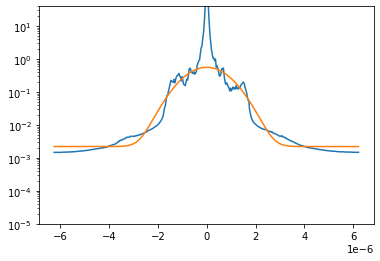

In [136]:
plt.plot(delay_array, window_vis_vals)
plt.plot(delay_array, gaussian_fit_result.x[0]*np.exp(-delay_array**2/(gaussian_fit_result.x[1])**2/2)+gaussian_fit_result.x[2])
#plt.xlim([-1e-6,1e-6])
#plt.ylim([.001,300])
plt.ylim([1e-5,40])
plt.yscale("log")
plt.show()

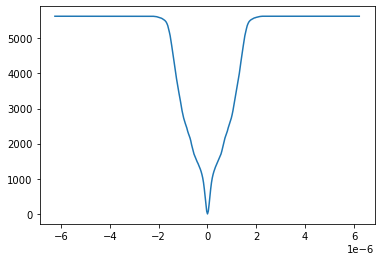

In [140]:
plt.plot(delay_array, window_vis_n)
plt.show()

In [13]:
boundary_slope = 0.6284790822752272
c = 3e8
wedge_var = 7.060438044132621
window_var = 0.09310922310592183

weighting_function = np.full((data.Nbls, data.Nfreqs), window_var)
for delay_ind, delay_val in enumerate(delay_array):
    wedge_bls = np.where(
        bl_lengths * boundary_slope / c + wedge_buffer > np.abs(delay_val)
    )[0]
    if len(wedge_bls) > 0:
        weighting_function[wedge_bls, delay_ind] = wedge_var
        
# bin results
bl_lengths = np.sqrt(np.sum(data.uvw_array**2.0, axis=1))
nbins = 100
min_val = np.min(bl_lengths)
max_val = np.max(bl_lengths)
bl_bin_edges = np.linspace(min_val, max_val, num=nbins + 1)
binned_weighting = np.full([nbins, data.Nfreqs], np.nan, dtype="float")
for bin_ind in range(nbins):
    bl_inds = np.where(
        (bl_lengths > bl_bin_edges[bin_ind])
        & (bl_lengths <= bl_bin_edges[bin_ind + 1])
    )[0]
    if len(bl_inds) > 0:
        binned_weighting[bin_ind, :] = np.mean(
            weighting_function[bl_inds, :], axis=0
        )

1.3150439201403261


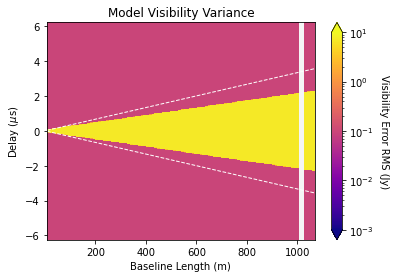

In [14]:
print(np.nanmean(np.abs(binned_delay_spec_diff**2.-binned_weighting)))
plot_delay_spectra(
    binned_weighting,
    bin_edges,
    delay_array,
    title="Model Visibility Variance",
    add_lines=[1.0],
    vmin=1e-3,
    vmax=1e1,
)

1.3150439201403261


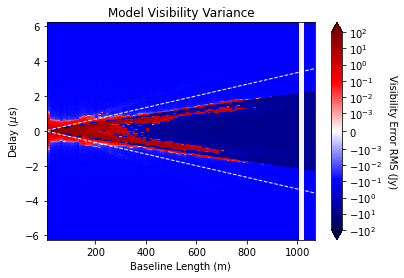

In [15]:
print(np.nanmean(np.abs(binned_delay_spec_diff**2.-binned_weighting)))
plot_delay_spectra(
    binned_delay_spec_diff**2.-binned_weighting,
    bin_edges,
    delay_array,
    title="Model Visibility Variance",
    add_lines=[1.0],
    vmin=-1e2,
    vmax=1e2,
)

1.5486048099872767


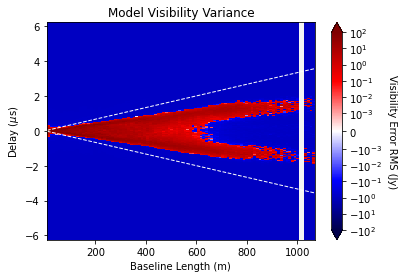

In [16]:
print(np.nanmean(np.abs(binned_delay_spec_diff**2.-np.nanmean(binned_delay_spec_diff**2.))))
plot_delay_spectra(
    binned_delay_spec_diff**2.-np.nanmean(binned_delay_spec_diff**2.),
    bin_edges,
    delay_array,
    title="Model Visibility Variance",
    add_lines=[1.0],
    vmin=-1e2,
    vmax=1e2,
)

In [137]:
def get_weights_with_gaussian_window_fit(
    Nfreqs,
    Nbls,
    uvw_array,
    channel_width_hz,
    wedge_slope_factor=0.6284790822752272,
    wedge_delay_buffer=6.5e-8,
    wedge_variance=7.101176738469631,
    #window_min_variance=2.38625311e-02,
    window_min_variance=2.21780714e-03,
    #window_gaussian_amp=6.73642264e00,
    window_gaussian_amp=5.62605392e-01,
    #window_gaussian_stddev=6.58794760e-07,
    window_gaussian_stddev=7.97851927e-07,
):

    c = 3.0 * 10**8  # Speed of light
    bl_lengths = np.sqrt(np.sum(uvw_array**2.0, axis=1))
    delay_array = np.fft.fftfreq(Nfreqs, d=channel_width_hz)
    delay_weighting = np.full((Nbls, Nfreqs), wedge_variance)
    for delay_ind, delay_val in enumerate(delay_array):
        window_bls = np.where(
            wedge_slope_factor * bl_lengths / c + wedge_delay_buffer
            <= np.abs(delay_val)
        )[0]
        delay_weighting[window_bls, delay_ind] = (
            window_gaussian_amp
            * np.exp(-(delay_val**2) / window_gaussian_stddev**2 / 2)
            + window_min_variance
        )
    return delay_array, delay_weighting

def get_weighted_weight_mat(
    Nfreqs,
    Nbls,
    uvw_array,
    channel_width_hz,
    wedge_slope_factor=0.628479,
    wedge_delay_buffer=6.5e-8,
    downweight_frac=0.0131875,
):

    c = 3.0 * 10**8  # Speed of light
    bl_lengths = np.sqrt(np.sum(uvw_array**2.0, axis=1))
    delay_array = np.fft.fftfreq(Nfreqs, d=channel_width_hz)
    delay_weighting = np.ones((Nbls, Nfreqs))
    for delay_ind, delay_val in enumerate(delay_array):
        wedge_bls = np.where(
            wedge_slope_factor * bl_lengths / c + wedge_delay_buffer > np.abs(delay_val)
        )[0]
        delay_weighting[wedge_bls, delay_ind] = downweight_frac
    return delay_array, delay_weighting

In [138]:
delays_new, weighting = get_weights_with_gaussian_window_fit(
    data.Nfreqs,
    data.Nbls,
    data.uvw_array,
    data.channel_width
)

delays_new = np.fft.fftshift(delay_array)
weighting = np.fft.fftshift(weighting, axes=1)

# bin results
bl_lengths = np.sqrt(np.sum(data.uvw_array**2.0, axis=1))
nbins = 100
min_val = np.min(bl_lengths)
max_val = np.max(bl_lengths)
bl_bin_edges = np.linspace(min_val, max_val, num=nbins + 1)
binned_weighting = np.full([nbins, data.Nfreqs], np.nan, dtype="float")
for bin_ind in range(nbins):
    bl_inds = np.where(
        (bl_lengths > bl_bin_edges[bin_ind])
        & (bl_lengths <= bl_bin_edges[bin_ind + 1])
    )[0]
    if len(bl_inds) > 0:
        binned_weighting[bin_ind, :] = np.mean(
            weighting[bl_inds, :], axis=0
        )

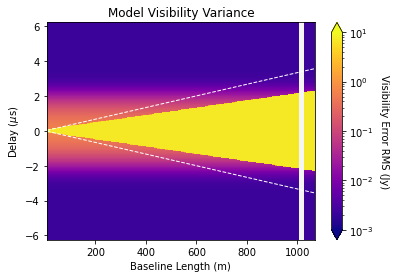

In [139]:
plot_delay_spectra(
    binned_weighting,
    bin_edges,
    delay_array,
    title="Model Visibility Variance",
    add_lines=[1.0],
    vmin=1e-3,
    vmax=1e1,
)